In [36]:
import numpy as np
import json
import yaml
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
directory = cfg["dataset"]["dirname"]
image_directory = cfg["dataset"]["images"]
languages = cfg["languages"]

In [38]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2') #distiluse-base-multilingual-cased-v1') #
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [39]:
def reshape(im):
    print("This is size of original image:",im.size, "\n")
    width, height = im.size
    # print("W: {} and H: {}".format(width, height))
    if width > 1000 or height > 1000:
        scale = 3
    elif width > 500 or height > 500:
        scale = 2
    else:
        scale = 1    
    new_width = int(width / scale)
    new_height = int(height / scale)
    #image = preprocess(im)
    image = fn.resize(im, size=[new_width])
    print("This is size of resized image:",image.size, "\n")
    return image

In [40]:
def get_logits(image_features, text_features):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text  

In [41]:
def sbert_to_clip(sbert_features, name_model):
    splitted_name = name_model.split("_")
    hidden_size = int(splitted_name[2])
    input_size = sbert_features.shape[1]
    PATH = os.path.join("models",name_model)
    model = SCLIPNN(input_size,hidden_size)
    print("DEBUG 4")
    model.load_state_dict(torch.load(PATH))
    print("DEBUG 5")
    model.eval()
    output = model(sbert_features)
    print("DEBUG 6")
    return output

In [42]:
def get_image(directory, image_id):
    image = Image.open(directory + image_id)
    return image

In [43]:
def reciprocal_rank(probs, value):
    N = len(probs)
    copy_probs = list(probs.copy())
    for i in range(N):
        max_value = max(copy_probs)
        if max_value == value:
            return 1/(i + 1)
        else:
            copy_probs.remove(max_value)
    return 1/N

In [44]:
def run_multilingual_experiment(name_of_model, directory, languages):
    sbert_lang_performance = []
    clip_lang_performance = []
    sbert_lang_errors = []
    clip_lang_errors = []
    sbert_lang_mrr = []
    clip_lang_mrr = []
    vetoed = []
    for lang, code in languages.items():
        #print("Processing captions in "+ lang +"...")
        f_json =  open(directory + code + "_pairs.json",mode='r',encoding='utf-8')
        pairs_data = json.load(f_json)
        images = []
        captions = []
        for pair in pairs_data:
            images.append(pair["image_id"])
            captions.append(pair["caption"])

        with torch.no_grad():
            try:
                torch_features = torch.from_numpy(sbert_model.encode(captions))
                print("DBUG 1")
                sbert_features = sbert_to_clip(torch_features,name_of_model).type(torch.float16)
                print("DBUG 2")
                tokenized_features = clip.tokenize(captions).to(device)
                print("DBUG 3")
                clip_features = clip_model.encode_text(tokenized_features)
            except:
                print("Not able to tokenize in {}. Skipping language {}".format(lang, code))
                vetoed.append(lang)
                continue

            sbert_performance = []
            clip_performance = []
            sbert_errors = 0
            clip_errors = 0
            sbert_rr = 0
            clip_rr = 0
            counter = 0

            for image_id in images:
                # Get the encoding of the image
                im = get_image(image_directory, image_id)
                image = preprocess(im).unsqueeze(0).to(device)
                image_features = clip_model.encode_image(image)

                # Get the probabilities for SBERT and CLIP
                logits_image_sbert, logits_text_sbert = get_logits(image_features, sbert_features)
                logits_image_clip, logits_text_clip = get_logits(image_features, clip_features)
                probs_clip = logits_image_clip.softmax(dim=-1).cpu().numpy()
                probs_sbert = logits_image_sbert.softmax(dim=-1).cpu().numpy()

                # Append the probs to array            
                ps = probs_sbert[0][counter]
                sbert_rr += reciprocal_rank(probs_sbert[0],ps)
                sbert_performance.append(ps)
                if ps < max(probs_sbert[0]):
                    sbert_errors += 1
                pc = probs_clip[0][counter]
                clip_rr += reciprocal_rank(probs_clip[0],pc)
                clip_performance.append(pc)
                if pc < max(probs_clip[0]):
                    clip_errors += 1
                counter += 1

        # print("Images processed: {}".format(counter))
        # print("Classifications errors: SBERT --> {} ; CLIP --> {}".format(sbert_errors,clip_errors))
        sbert_lang_performance.append(round(sum(sbert_performance)/counter,6))
        clip_lang_performance.append(round(sum(clip_performance)/counter,6))
        sbert_lang_mrr.append(round(sbert_rr/counter,4))
        clip_lang_mrr.append(round(clip_rr/counter,4))
        sbert_lang_errors.append(sbert_errors)
        clip_lang_errors.append(clip_errors)
    #print("Done")
    #print("Forbidden Languages: {}".format(vetoed))
    return sbert_lang_mrr, clip_lang_mrr

In [45]:
def show_plot(languages, sbert_lang_mrr, clip_lang_mrr):
    X_axis = np.arange(len(languages.keys()))
    figure_name = plt.figure(figsize=(20, 8))
    plt.bar(X_axis-0.2, sbert_lang_mrr, 0.4, color = 'blue', edgecolor = 'black', capsize=7, label='SBERT MRR')
    plt.bar(X_axis+0.2, clip_lang_mrr, 0.4, color = 'red', edgecolor = 'black', capsize=7, label='CLIP MRR')
    plt.xticks(rotation = 45)
    plt.xticks(X_axis, languages.keys())
    plt.legend()
    plt.show()

In [47]:
models = [x for x in os.listdir('models') if 'e250' in x]
print("Languages: {}".format(languages))
for model in models:
    sbert_lang_mrr, clip_lang_mrr = run_multilingual_experiment(model, directory, languages)
    print("Name of the model: {}".format(model))    
    print("SBERT performance: {}".format(sbert_lang_mrr))
    print("CLIP performance: {}".format(clip_lang_mrr))
    show_plot(languages, sbert_lang_mrr, clip_lang_mrr)
    print('-'*100)    

Languages: {'English': 'en', 'Spanish': 'es', 'Italian': 'it', 'German': 'de', 'French': 'fr'}
DBUG 1
DEBUG 4
DEBUG 5
DEBUG 6
DBUG 2
DBUG 3
DBUG 1
DEBUG 4
DEBUG 5
DEBUG 6
DBUG 2
DBUG 3
DBUG 1
DEBUG 4
DEBUG 5
DEBUG 6
DBUG 2
DBUG 3
DBUG 1
DEBUG 4
DEBUG 5
DEBUG 6
DBUG 2
DBUG 3


KeyboardInterrupt: 

In [75]:
results = pd.DataFrame({"SBERT":sbert_lang_performance, "CLIP": clip_lang_performance,
                        "error SBERT":sbert_lang_errors, "error CLIP":clip_lang_errors,
                       "MRR sbert":sbert_lang_mrr, "MRR clip": clip_lang_mrr}, 
                       index=languages)
results

,SBERT,CLIP,error SBERT,error CLIP,MRR sbert,MRR clip
English,0.063924,0.091794,25,18,0.7825,0.8511
Spanish,0.057844,0.039343,30,38,0.7374,0.6481
Italian,0.058054,0.034438,33,45,0.7144,0.5564
German,0.059676,0.033382,27,44,0.7567,0.5554
French,0.062021,0.042905,29,33,0.7523,0.6816


Languages: {'English': 'en', 'Spanish': 'es', 'Italian': 'it', 'German': 'de', 'French': 'fr'}
DBUG 1
DEBUG 4
Not able to tokenize in English. Skipping language en
DBUG 1
DEBUG 4
Not able to tokenize in Spanish. Skipping language es
DBUG 1
DEBUG 4
Not able to tokenize in Italian. Skipping language it
DBUG 1
DEBUG 4
Not able to tokenize in German. Skipping language de
DBUG 1
DEBUG 4
Not able to tokenize in French. Skipping language fr
Name of the model: coco_NN_900_e300_s200000.pt
SBERT performance: []
CLIP performance: []


ValueError: shape mismatch: objects cannot be broadcast to a single shape

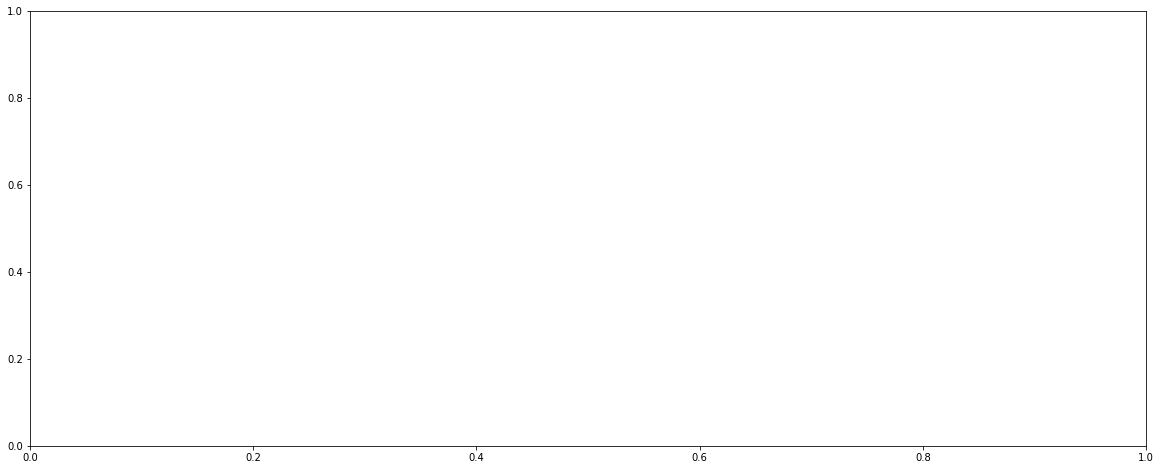

In [46]:
models = [x for x in os.listdir('models') if 'e300' in x]
print("Languages: {}".format(languages))
for model in models:
    sbert_lang_mrr, clip_lang_mrr = run_multilingual_experiment(model, directory, languages)
    print("Name of the model: {}".format(model))    
    print("SBERT performance: {}".format(sbert_lang_mrr))
    print("CLIP performance: {}".format(clip_lang_mrr))
    show_plot(languages, sbert_lang_mrr, clip_lang_mrr)
    print('-'*100)    